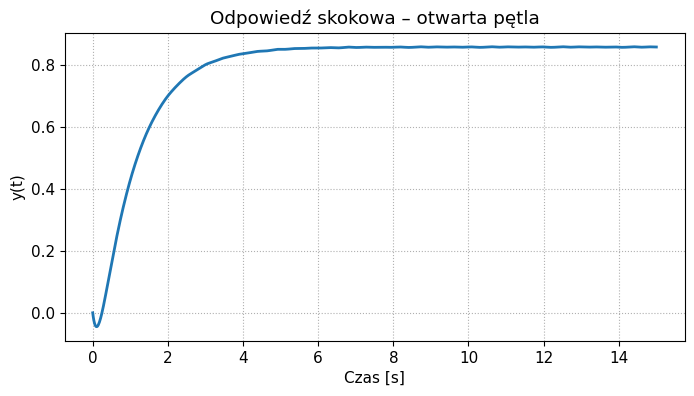

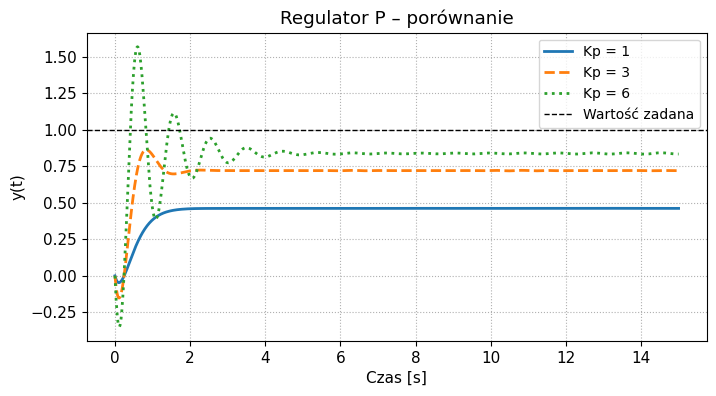

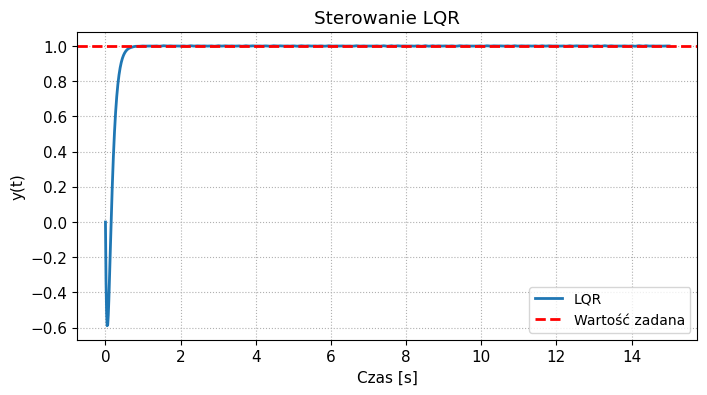

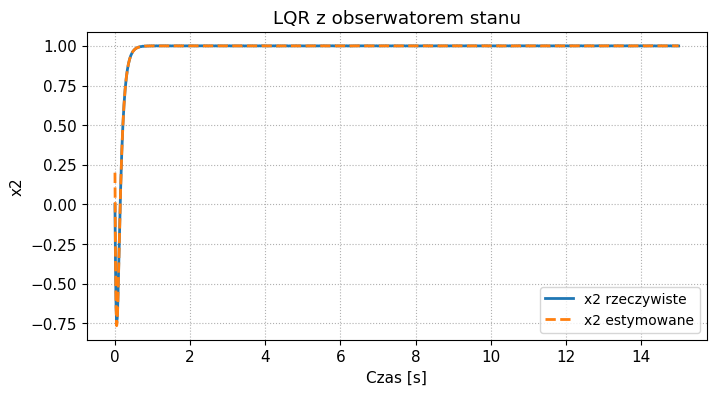

Gotowe – model dla (-s+6)/((s+1)(s+7)).


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import place_poles
from scipy.linalg import solve_continuous_are

# =========================================================
# STYL WYKRESÓW – MATLAB-LIKE
# =========================================================
plt.rcParams.update({
    "figure.figsize": (8, 4),
    "lines.linewidth": 2,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.linewidth": 0.8,
    "font.size": 11,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
})

# =========================================================
# 0. MODEL OBIEKTU
# G(s) = (-s + 6) / ((s+1)(s+7)) = (-s+6)/(s^2+8s+7)
# =========================================================

A = np.array([
    [0.0, -7.0],
    [1.0, -8.0]
])

B = np.array([
    [6.0],
    [-1.0]
])

C = np.array([[0.0, 1.0]])   # y = x2

t_span = (0, 15)
t_eval = np.linspace(0, 15, 1000)
x0 = np.zeros(2)

# =========================================================
# 1. ODPOWIEDŹ SKOKOWA – OTWARTA PĘTLA
# =========================================================

def open_loop(t, x):
    u = 1.0
    return A @ x + B.flatten() * u

sol_open = solve_ivp(open_loop, t_span, x0, t_eval=t_eval)

plt.figure()
plt.plot(sol_open.t, sol_open.y[1, :])
plt.xlabel("Czas [s]")
plt.ylabel("y(t)")
plt.title("Odpowiedź skokowa – otwarta pętla")
plt.show()

# =========================================================
# 2. REGULATOR P – PORÓWNANIE
# =========================================================

kp_values = [1, 3, 6]
styles = ['-', '--', ':']

plt.figure()

for kp, style in zip(kp_values, styles):

    def p_control(t, x):
        y = C @ x
        u = kp * (1.0 - y)
        return A @ x + B.flatten() * u

    sol_p = solve_ivp(p_control, t_span, x0, t_eval=t_eval)
    plt.plot(sol_p.t, sol_p.y[1, :], style, label=f"Kp = {kp}")

plt.axhline(1.0, color='k', linestyle='--', linewidth=1, label="Wartość zadana")
plt.xlabel("Czas [s]")
plt.ylabel("y(t)")
plt.title("Regulator P – porównanie")
plt.legend()
plt.show()

# =========================================================
# 3. LQR Z REFERENCJĄ
# =========================================================

big_mat = np.block([
    [A, B],
    [C, np.zeros((1, 1))]
])

rhs = np.array([0, 0, 1])
res = np.linalg.solve(big_mat, rhs)

x_ref = res[:2]
u_ref = res[2]

Q = np.diag([10, 10])
R = np.array([[1]])

P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ B.T @ P

def lqr_control(t, x):
    u = -K @ (x - x_ref) + u_ref
    return A @ x + B.flatten() * u

sol_lqr = solve_ivp(lqr_control, t_span, x0, t_eval=t_eval)

plt.figure()
plt.plot(sol_lqr.t, sol_lqr.y[1, :], label="LQR")
plt.axhline(1.0, color='r', linestyle='--', label="Wartość zadana")
plt.xlabel("Czas [s]")
plt.ylabel("y(t)")
plt.title("Sterowanie LQR")
plt.legend()
plt.show()

# =========================================================
# 4. LQR + OBSERWATOR LUENBERGERA
# =========================================================

eig_cl = np.linalg.eigvals(A - B @ K)
observer_poles = 3 * eig_cl

L = place_poles(A.T, C.T, observer_poles).gain_matrix.T

def observer_system(t, z):
    x = z[:2]
    x_hat = z[2:]

    y = C @ x
    y_hat = C @ x_hat

    u = (-K @ (x_hat - x_ref) + u_ref).item()

    dx = A @ x + B.flatten() * u
    dx_hat = A @ x_hat + B.flatten() * u + (L @ (y - y_hat)).flatten()

    return np.concatenate((dx, dx_hat))

z0 = np.array([0, 0, 0.2, 0.2])
sol_obs = solve_ivp(observer_system, t_span, z0, t_eval=t_eval)

plt.figure()
plt.plot(sol_obs.t, sol_obs.y[1, :], label="x2 rzeczywiste")
plt.plot(sol_obs.t, sol_obs.y[3, :], '--', label="x2 estymowane")
plt.xlabel("Czas [s]")
plt.ylabel("x2")
plt.title("LQR z obserwatorem stanu")
plt.legend()
plt.show()

print("Gotowe – model dla (-s+6)/((s+1)(s+7)).")
